In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

Load the users Data

In [2]:
userCols = ['userId', 'age', 'sex', 'occupation', 'zipCode']
users = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.user', sep = '|', names=userCols)

Load the rating data

In [3]:
dataCols = ['userId', 'itemId', 'rating', 'timestamp']
data = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', sep = '\t', names=dataCols)

Load items data

In [4]:
itemsCols = ['movieId', 'movieTitle' ,'releaseDate','videoReleaseDate', 'imdbUrl', 'unknown', 'Action', 'Adventure',
            'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
            'filmNoir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western']
items = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', names=itemsCols, encoding='latin-1')

Train and Test split - Organic in the data

In [5]:
rCols = ['userId', 'movieId', 'rating', 'unixTimestamp']

ratingsBase = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/ua.base',
                          sep='\t', names=rCols, encoding='latin-1')

ratingsTest = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/ua.test',
                          sep='\t', names=rCols, encoding='latin-1')

ratingsBase.shape, ratingsTest.shape

((90570, 4), (9430, 4))

### Top recomandations by age group and sex

In [80]:
def getRating(subSet, minVotes):
    subSet = pd.DataFrame(subSet)
    subSet.columns = ratingsBase.columns
    
    votes = Counter(subSet.movieId)
    
    meanRatingFull = []
    for movieId in items.movieId:
        if votes[movieId] >= minVotes:
            try:
                meanRatingFull.append([subSet.rating[subSet.movieId == movieId].mean(),
                                       str(items.movieTitle[items.movieId == movieId].iloc[0]),
                                      votes[movieId]])
            except:
                continue
            
    meanRatingFull = pd.DataFrame(meanRatingFull, columns=['rating', 'title', 'votes'])
    meanRatingSorted = meanRatingFull.sort_values('rating', ascending=False)[:10]
    
    return meanRatingSorted

In [98]:
def meanByAgeAndSex(userId, minVotes = 3):
    userSex = users.sex[users.userId == userId].iloc[0]
    userAgeGroup = users.ageGroup[users.userId == userId].iloc[0]
    userAge = users.age[users.userId == userId].iloc[0]

    
    userForSubset = users.userId[(users.sex == userSex) & (users.ageGroup == userAgeGroup)]
    
    subSet = []
    for i in range(len(ratingsBase)):
        if ratingsBase.userId[i] in userForSubset:
            subSet.append(list(ratingsBase.iloc[i])) 
        
    meanRatingSorted = getRating(subSet=subSet, minVotes=minVotes)
    
    print 'User {userId} is a {userAge} year old {userSex}'.format(
        userId=userId, userAge=userAge, userSex='Male' if userSex == 'M' else 'Female')
    
    return meanRatingSorted

Encode age groups to the data farme

In [78]:
ageGroup = {'young': range(7,13), 'teen': range(13,18), 'youngAdult': range(18, 30), 'adult': range(30,50),
            'old': range(50,120)}

g = []
for age in users.age:
    g.append([key for key in ageGroup if age in ageGroup[key]][0]) 
    
users['ageGroup'] = g

### Top recomandations by location

In [76]:
import urllib2
import json

In [75]:
def GetLatLng(Zip):
    API_KEY = '<Your API Key>'
    url = urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?address=' + str(Zip) + '&key=' + str(API_KEY))
    json_url = json.loads(url.read())
    lat = json_url['results'][0]['geometry']['location']['lat']
    lon = json_url['results'][0]['geometry']['location']['lng']
    name = json_url['results'][0]['address_components'][1]['short_name']
    county = json_url['results'][0]['address_components'][2]['long_name']
    state = json_url['results'][0]['address_components'][3]['long_name']
    
    return str(name), str(county), str(state), lat, lon

In [77]:
def meanByLocation(userId, minVotes = 2):
    userZipCode3 = users.zipCode[users.userId == userId].iloc[0][:3]

    userForSubset = []
    for i in range(len(users)):
        if users.zipCode[i][:3] == userZipCode3:
            userForSubset.append(users.userId[i])

    subSet = []
    for i in range(len(ratingsBase)):
        if ratingsBase.userId[i] in userForSubset:
            subSet.append(list(ratingsBase.iloc[i]))
    
    meanRatingSorted = getRating(subSet=subSet, minVotes=minVotes)
    
    location = GetLatLng(users.zipCode[users.userId == userId].iloc[0])
    
    print 'User {userId} is from {town}, {county}, {state}'.format(
        userId=userId, town=location[0], county=location[1], state=location[2])
    
    return meanRatingSorted

### Collaborative Filtering

In [7]:
from scipy.spatial.distance import euclidean as ed
from scipy.stats.stats import pearsonr as pc
from sklearn.metrics.pairwise import cosine_similarity as cs
import random

In [63]:
def compareTwo(firstUser, secondUser):
    first = ratingsBase[ratingsBase.userId == firstUser][[1,2]]
    second = ratingsBase[ratingsBase.userId == secondUser][[1,2]]
    merged = pd.merge(first, second, on='movieId')
    scorePc = pc(merged.rating_x, merged.rating_y)
    print 'PC score: {score:.2f} \np-value: {pval:.2f}'.format(score=scorePc[0], pval=scorePc[1])
    sns.pairplot(merged, vars=['rating_x', 'rating_y'], kind='reg', size=3, diag_kind='kde')

In [9]:
def didntWatch(firstUser, secondUser):
    moviesFirstUser = ratingsBase[ratingsBase.userId == firstUser][['movieId']]
    moviesSecondUser = ratingsBase[ratingsBase.userId == secondUser][['movieId']]
    
    moviesFirstUser.index = range(len(moviesFirstUser))
    moviesSecondUser.index = range(len(moviesSecondUser))
    
    didntWatch = []
    for i in range(len(moviesSecondUser.movieId)): 
        if moviesSecondUser.movieId[i] not in list(moviesFirstUser.movieId):
            didntWatch.append(moviesSecondUser.movieId[i])
            
    return didntWatch

In [10]:
def collaborativeFiltering(userId, minMatch = 10, method = 'pc', sample = len(ratingsBase.userId.unique()), returnNo = 5):
    userRatings= ratingsBase[ratingsBase.userId == userId][[1,2]]

    if method == 'pc':
        pcAndUserId = []
        for user in random.sample(ratingsBase.userId.unique(), sample):
            tempUserRating = ratingsBase[ratingsBase.userId == user][[1,2]]
            merged = pd.merge(userRatings, tempUserRating, on='movieId')
            if userId == user:
                continue
            if len(merged) > minMatch:
                pcCompute = pc(merged.rating_x, merged.rating_y)
                pcAndUserId.append([user, pcCompute[0], pcCompute[1]])

        return pd.DataFrame(pcAndUserId, columns=['userId', 'pc', 'p-value']).sort_values(by='pc', ascending=False)[:returnNo]
    
    elif method == 'ed':
        pcAndUserId = []
        for user in random.sample(ratingsBase.userId.unique(), sample):
            tempUserRating = ratingsBase[ratingsBase.userId == user][[1,2]]
            merged = pd.merge(userRatings, tempUserRating, on='movieId')
            if userId == user:
                continue
            if len(merged) > minMatch:
                pcCompute = ed(merged.rating_x, merged.rating_y)
                pcAndUserId.append([user, pcCompute])
                
        return pd.DataFrame(pcAndUserId, columns=['userId', 'ed']).sort_values(by='ed', ascending=True)[:returnNo]

    elif method == 'cs':
        pcAndUserId = []
        for user in random.sample(ratingsBase.userId.unique(), sample):
            tempUserRating = ratingsBase[ratingsBase.userId == user][[1,2]]
            merged = pd.merge(userRatings, tempUserRating, on='movieId')
            if userId == user:
                continue
            if len(merged) > minMatch:
                pcCompute = cs(merged.rating_x, merged.rating_y)
                pcAndUserId.append([user, pcCompute[0][0]])

        return pd.DataFrame(pcAndUserId, columns=['userId', 'cs']).sort_values(by='cs', ascending=False)[:returnNo]

In [22]:
def printMatches(userId, bestMatch, method):
    userId = userId
    age = users.age[users.userId == userId].iloc[0]
    sex = users.sex[users.userId == userId].iloc[0]
    
    if method == 'pc':
        method = 'pearson correlation'
    elif method == 'ed':
        method = 'euclidean distance'
    else:
        method = 'cosine similarity'
    
    bestuserId = bestMatch.userId.iloc[0]
    bestage = users.age[users.userId == bestMatch.userId.iloc[0]].iloc[0]
    bestsex = users.sex[users.userId == bestMatch.userId.iloc[0]].iloc[0]
    seconduserId = bestMatch.userId.iloc[1]
    secondage = users.age[users.userId == bestMatch.userId.iloc[1]].iloc[0]
    secondsex = users.sex[users.userId == bestMatch.userId.iloc[1]].iloc[0]
    thirduserId = bestMatch.userId.iloc[2]
    thirdage = users.age[users.userId == bestMatch.userId.iloc[2]].iloc[0]
    thirdsex = users.sex[users.userId == bestMatch.userId.iloc[2]].iloc[0]

    print '''User {userId}, a {age} year old {sex}, was mached based on {method} with:
    
1. User {bestuserId}, a {bestage} year old {bestsex}
2. User {seconduserId}, a {secondage} year old {secondsex}
3. User {thirduserId}, a {thirdage} year old {thirdsex}
'''.format(userId=userId,age=age,sex='Male' if sex == 'M' else 'Female',
            method=method,bestuserId=bestuserId,
            bestage=bestage,bestsex='Male' if bestsex == 'M' else 'Female',seconduserId=seconduserId,
            secondage=secondage,secondsex='Male' if secondsex == 'M' else 'Female',thirduserId=thirduserId,
            thirdage=thirdage,thirdsex='Male' if thirdsex == 'M' else 'Female')


In [12]:
def recommendCollaborativeFiltering(userId, minMatch = 10, method = 'pc', recommendNumber = 5,
                                    sample = len(ratingsBase.userId.unique())):
    
    bestMatch = collaborativeFiltering(userId=userId, minMatch=minMatch, method=method, sample=sample)[['userId']]
    
    firstForMerge = ratingsBase[ratingsBase.userId == bestMatch.userId.iloc[0]][['movieId', 'rating']]
    
    dWatch = didntWatch(userId, bestMatch.userId.iloc[0])
    
    printMatches(userId=userId, bestMatch=bestMatch, method=method)
    
    firstForMergeDidntWatch = pd.DataFrame()
    for i in range(1, len(dWatch)):
        firstForMergeDidntWatch = firstForMergeDidntWatch.append(firstForMerge[firstForMerge.movieId == dWatch[i]],
                                                                 ignore_index=True)
            
    merged = pd.merge(firstForMergeDidntWatch,
                      ratingsBase[ratingsBase.userId == bestMatch.userId.iloc[1]][['movieId', 'rating']],
                      on = 'movieId')
    
    for i in range(2, len(bestMatch)):
        backupMerged = merged
        merged = pd.merge(merged, ratingsBase[ratingsBase.userId == bestMatch.userId.iloc[i]][['movieId', 'rating']],
                          on = 'movieId')
        if (merged.shape[0] <= recommendNumber):
            break

    if (merged.shape[0] <= recommendNumber):
        return backupMerged
    else:
        return merged

In [39]:
def movieRecommendCF(userId, minMatch = 10, method = 'pc', recommendNumber = 5,
                     sample = len(ratingsBase.userId.unique())):
    ''' 
    userId: from the dataset
    minMatch: min number of matches in the merged DF
    method: pearson correlation ("pc"), euclidean distance ("ed), cosine similarity ("cs")
    sample: number of samples from the data with witch to match (auto: max)
    recommendNumber: number of recommendations to generate
    '''
    try: 
        fullMatrix = recommendCollaborativeFiltering(userId=userId, minMatch=minMatch, method=method, sample=sample,
                                                     recommendNumber=recommendNumber)

        finalScore = list(fullMatrix.drop(['movieId'], axis=1).sum(axis=1))
        fullMatrix['finalScore'] = finalScore
        fullMatrix = fullMatrix.sort_values('finalScore', ascending=False)

        movieTitle = []
        for movieId in fullMatrix.movieId:
            movieTitle.append(str(items.movieTitle[items.movieId == movieId].iloc[0]))

        fullMatrix['movieTitle'] = movieTitle

        if fullMatrix.shape[0] <= recommendNumber:
            fullMatrix.index = range(1, fullMatrix.shape[0]+1)
            return fullMatrix[['movieTitle', 'finalScore']]
        else:
            fullMatrix.index = range(1, fullMatrix.shape[0]+1)
            return fullMatrix[['movieTitle', 'finalScore']][:recommendNumber]
    except IndexError:
        print 'Reduce the number of minMatch'

# Collaborative Filtering (CF) recommender engine

In [88]:
movieRecommendCF(73, method='pc', recommendNumber=5, minMatch=20)

User 73, a 24 year old Male, was mached based on pearson correlation with:
    
1. User 177, a 20 year old Male
2. User 894, a 47 year old Male
3. User 537, a 36 year old Male



,movieTitle,finalScore
1,"Usual Suspects, The (1995)",22
2,Star Wars (1977),22
3,Lone Star (1996),20
4,"City of Lost Children, The (1995)",18
5,Contact (1997),17


### Graph top match

PC score: 0.68 
p-value: 0.00


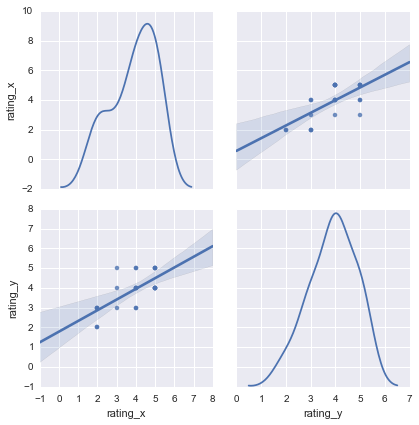

In [89]:
compareTwo(73, 177)

# Location based recommender engine

In [96]:
meanByLocation(1, minVotes=3)

User 1 is from Tucson, Pima County, Arizona


,rating,title,votes
0,5.000000,Star Wars (1977),3
1,4.666667,"Godfather, The (1972)",3
2,4.333333,Return of the Jedi (1983),3
3,4.000000,"Full Monty, The (1997)",3


# demographic based recommender engine

In [99]:
meanByAgeAndSex(47, minVotes=3)

User 47 is a 53 year old Male


,rating,title,votes
138,5.000000,Jean de Florette (1986),4
523,5.000000,Microcosmos: Le peuple de l'herbe (1996),3
702,4.750000,Some Folks Call It a Sling Blade (1993),4
277,4.555556,Schindler's List (1993),27
340,4.500000,"Close Shave, A (1995)",16
241,4.500000,Sense and Sensibility (1995),24
595,4.500000,Shadowlands (1993),8
399,4.500000,"Apartment, The (1960)",6
396,4.454545,"Philadelphia Story, The (1940)",11
36,4.444444,Ed Wood (1994),9
